# <div align="center">Clustering State Level COVID Economic Metrics</div> #


**<div align="center">Barrett Nibling</div>**
**<div align="center">bnibling@gmail.com</div>**


## Background ##

Since April this year (2020), it is an undisputed fact that the US economy has been in a complete shamble. With the onset of a catastrophic pandemic, millions of Americans were laid off and forced into unemployment as states across the land felt the rippling effects of COVID-19 and the subsequent lockdowns. According to the U.S. Bureau of Labor Statistics, the national unemployment rate nearly reached 15% (14.7%) earlier this year (Apr-2020). One of the biggest victims of all of this is the small businesses that are struggling to stay open in these trying times. 

In order to better understand the effects that COVID-19 has had on the US economy, this project aims to implement unsupervised machine learning clustering techniques on various economic metrics, so that can the economic status of each US state can be classified accordingly in a simplify and easy to interpret manner. 

To do so, this notebook attempts to answer the following questions:

1. Can various state-level economic metrics during the pandemic be classified through clustering methods?
2. Can these clusters be clearly seen through visualizations that utilize dimensionality reduction techniques?
3. Can these labels be used to demonstrate whether a given state is trending towards or away from economical stability?

The methods and techniques used to answer these questions are as follows:
1. Extract, clean and merge the various average state-level economic metrics into one dataframe for modeling.
2. Visualize the data and check that there are no outliers can could affect the clustering.
3. Scale the data for modeling. (Also, plotted the first two components of PCA to get an idea of the variance in the data.)
4. Model the data using various clustering methods: KMeans, Gaussian Mixture Models, Agglomerative Hierarchical Clustering, and DBSCAN. Picking the model with the most well defined and balanced cluster groups.
5. Define the cluster labels in easy to understand terminologies.
6. Visualize the clusters using both PCA and UMAP visualizations.
7. Plot a choropleth map of the US with corresponding cluster labels.

## Data: Opportunity Insights Economic Tracker Repository, Data Documentation, and Dictionary

This project will analyze the Opportunity Insights Economic Tracker repository to explore the various economic metrics it contains pertaining to the status of state-level economies across the US.

Namely this project will explore the following 6 economic metrics found in the tracker:

·  	**Average State-level Credit/Debit Card Spending**- data from Affinity Solutions

·  	**Average State-level Job Postings**- data from Burning Glass Technologies

·  	**Average State-level Employment Levels**- data from Paychex, Earnin, and Intuit

·  	**Average State-level Unemployment Insurance Claims**- data from the Department of Labor

·  	**Average State-level Small Business Openings**- data from Womply

·  	**Average State-level Small Business Net Revenue**- data from Womply

Additionally, the repository contains a GeoID dataset, that can be used to match FIP codes in the data.

**It is important to note that all values in these datasets are normalized percentages based on their respective January 2020 average. For example, a value of -0.05 in average job postings in March would indicate a decrease of 0.05 from the job postings average that was measured in January for that given geographic-level.**

The Opportunity Insights Economic Tracker Repository can be found on github through the following link: https://github.com/OpportunityInsights/EconomicTracker

Documentation about the Repository: https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_documentation.md

Data Dictionary: https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_dictionary.md



In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


pd.set_option("display.max_columns", None)

import plotly

<IPython.core.display.Javascript object>

## Data Extraction, Cleaning, and Merging

Fortunately, the usability of these datasets are very high and minimal data cleaning was needed. However, since these datasets are provided by different sources, the date values and frequency of updates varies among them. While the smallest common grain would be to group the datasets by weekly mean values, it is best to simplify the process and group by a monthly averages for all data sets. For future updates to this notebook, a weekly aggregation could be explored.



Furthermore, since this project is pertaining to the effects of COVID on different state-level economies, all data before April is dropped. Therefore, the data range for the project is from April 2020 through September 2020 (the last month where all metrics have been updated as of writing this).

Also, each dataset contains various features pertaining to various aspects of the given metric. For this notebook, only the overall average of each will be used (often labeled with a `combined` or `all` tag).

The following contains the code used to upload, clean, and group each data by monthly averages before merging them together by state FIP.

In [3]:
spending_df = pd.read_csv("./data/Affinity - State - Daily.csv")
jobposting_df = pd.read_csv("./data/Burning Glass - State - Weekly.csv")
employment_df = pd.read_csv("./data/Employment Combined - State - Daily.csv")
uiclaims_df = pd.read_csv("./data/UI Claims - State - Weekly.csv")
sbopen_df = pd.read_csv("./data/Womply Merchants - State - Daily.csv")
sbrev_df = pd.read_csv("./data/Womply Revenue - State - Daily.csv")
geo_df = pd.read_csv("./data/GeoIDs - State.csv")
# us_census_st_df = pd.read_csv("./data/us census bureau regions and divisions.csv")

<IPython.core.display.Javascript object>

In [4]:
spending_df = spending_df.loc[(spending_df["month"] >= 4) & (spending_df["month"] <= 9)]
spending_df["spend_all"] = spending_df["spend_all"].astype(float)
spending_df = spending_df.rename(columns={"spend_all": "avg_spending"})
spending_df = spending_df[["month", "statefips", "avg_spending"]]
spending_df_grp = spending_df.groupby(["month", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [5]:
jobposting_df = jobposting_df.loc[
    (jobposting_df["month"] >= 4) & (jobposting_df["month"] <= 9)
]
jobposting_df = jobposting_df.rename(columns={"bg_posts": "avg_jobpost"})
jobposting_df = jobposting_df[["month", "statefips", "avg_jobpost"]]
jobposting_df_grp = jobposting_df.groupby(["month", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [6]:
employment_df = employment_df.loc[
    (employment_df["month"] >= 4) & (employment_df["month"] <= 9)
]
employment_df = employment_df.rename(columns={"emp_combined": "avg_emprate"})
employment_df = employment_df[["month", "statefips", "avg_emprate"]]
employment_df_grp = employment_df.groupby(["month", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [7]:
uiclaims_df = uiclaims_df.loc[(uiclaims_df["month"] >= 4) & (uiclaims_df["month"] <= 9)]
uiclaims_df = uiclaims_df.rename(
    columns={"initclaims_rate_combined": "avg_uiclaimrate"}
)
uiclaims_df = uiclaims_df[["month", "statefips", "avg_uiclaimrate"]]
uiclaims_df_grp = uiclaims_df.groupby(["month", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [8]:
sbopen_df = sbopen_df.loc[(sbopen_df["month"] >= 4) & (sbopen_df["month"] <= 9)]
sbopen_df = sbopen_df.rename(columns={"merchants_all": "avg_sbopen"})
sbopen_df = sbopen_df[["month", "statefips", "avg_sbopen"]]
sbopen_df_grp = sbopen_df.groupby(["month", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [9]:
sbrev_df = sbrev_df.loc[(sbrev_df["month"] >= 4) & (sbrev_df["month"] <= 9)]
sbrev_df = sbrev_df.rename(columns={"revenue_all": "avg_sbrev"})
sbrev_df = sbrev_df[["month", "statefips", "avg_sbrev"]]
sbrev_df_grp = sbrev_df.groupby(["month", "statefips"]).mean()

<IPython.core.display.Javascript object>

In [10]:
econ_grp_dfs = [
    spending_df_grp,
    jobposting_df_grp,
    employment_df_grp,
    uiclaims_df_grp,
    sbopen_df_grp,
    sbrev_df_grp,
]

econ_df_merged = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        left_on=["month", "statefips"],
        how="inner",
        right_on=["month", "statefips"],
    ),
    econ_grp_dfs,
)
econ_df_merged.reset_index(inplace=True)

econ_df_merged = (
    econ_df_merged.reset_index().merge(geo_df, how="left").set_index("index")
)
econ_df_merged = econ_df_merged.drop(["statefips", "state_pop2019"], 1)

<IPython.core.display.Javascript object>

In [11]:
econ_df_merged

,month,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,statename,stateabbrev
index,,,,,,,,,
0,4,-0.212500,-0.308750,-0.173867,3.66250,-0.333433,-0.342133,Alabama,AL
1,4,-0.299033,-0.262250,-0.201133,3.53250,-0.389600,-0.442033,Alaska,AK
2,4,-0.269800,-0.382500,-0.156800,2.50500,-0.324100,-0.374333,Arizona,AZ
3,4,-0.110450,-0.460250,-0.156873,2.58250,-0.260100,-0.269567,Arkansas,AR
4,4,-0.340300,-0.329750,-0.217133,3.12750,-0.407467,-0.472700,California,CA
...,...,...,...,...,...,...,...,...,...
301,9,-0.045581,-0.170100,-0.072250,0.30575,-0.231200,-0.253567,Virginia,VA
302,9,-0.081610,-0.276000,-0.046780,0.71175,-0.263733,-0.279833,Washington,WA
303,9,0.049983,-0.007700,-0.087643,0.25475,-0.208467,-0.184061,West Virginia,WV


<IPython.core.display.Javascript object>

## Modeling Prep

This step is pretty straight forward. Dropped all the categorical values that won't go through the model and ran a pairplot to make sure none of the features have an outliers. Don't expect this to be the case because the data was previously normalized to January and the date range is fairly small.

After that checked out, it is time to rescale the data with StandardScaler and visualize the first 2 components of PCA to see see if it provides any initial insight.

In [12]:
X = econ_df_merged.drop(["month", "statename", "stateabbrev"], 1)

<IPython.core.display.Javascript object>

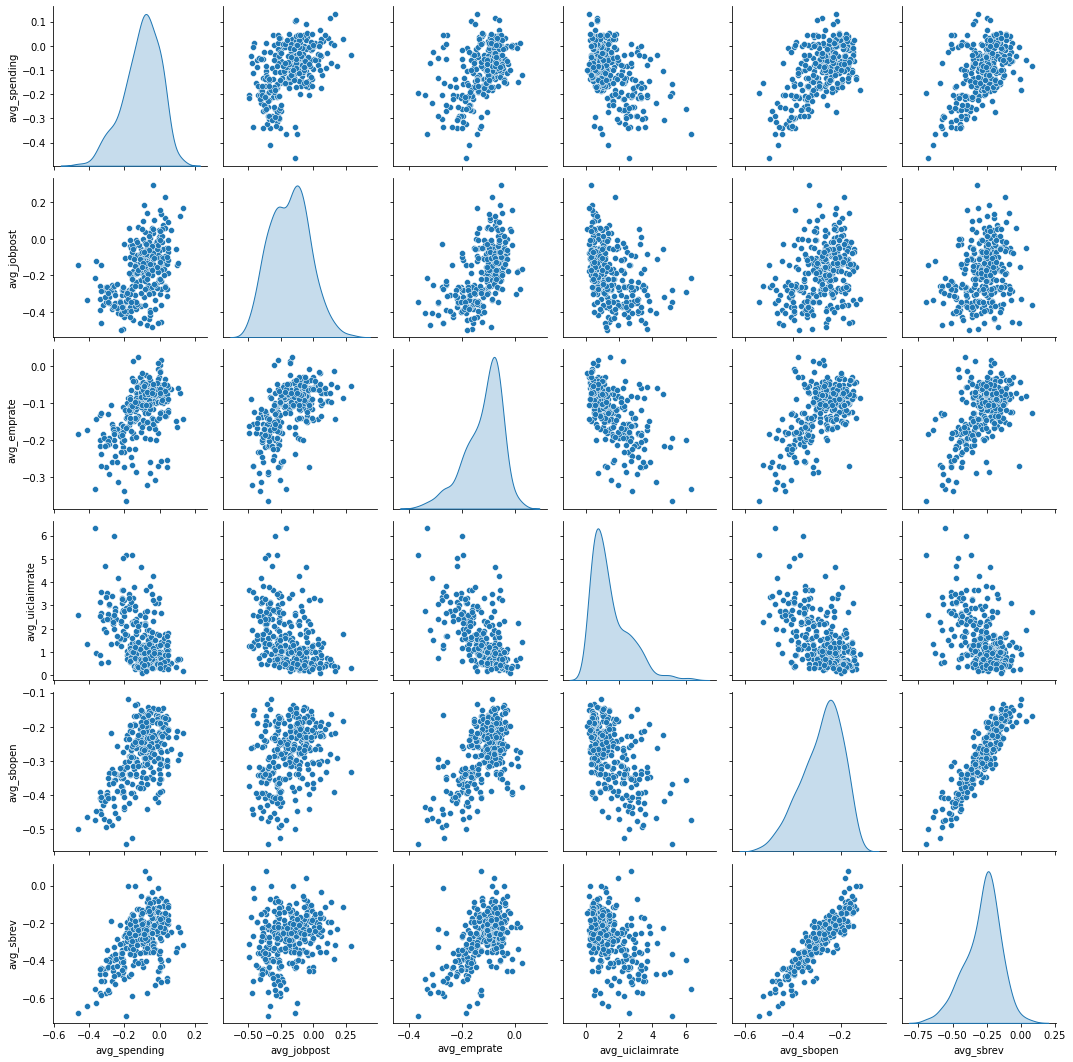

<IPython.core.display.Javascript object>

In [13]:
sns.pairplot(data=X, diag_kind="kde")
plt.show()

In [14]:
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

<IPython.core.display.Javascript object>

In [15]:
pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(X_std), columns=["c0", "c1"])
pca_df["month"] = econ_df_merged["month"]

<IPython.core.display.Javascript object>

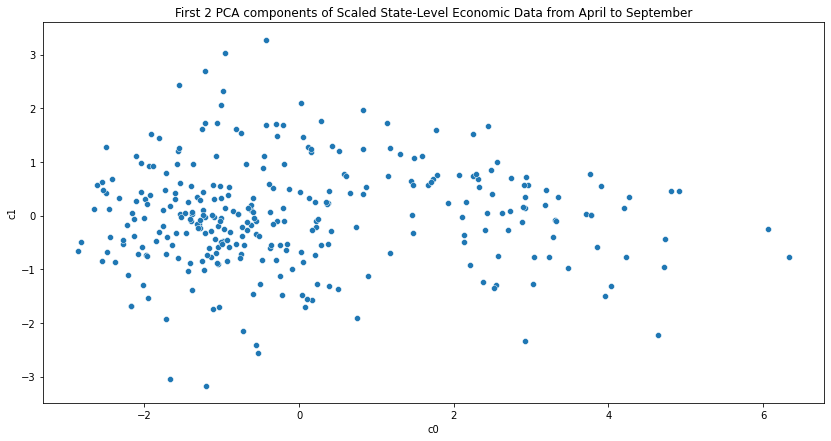

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=pca_df, x="c0", y="c1")
plt.title(
    "First 2 PCA components of Scaled State-Level Economic Data from April to September"
)
plt.show()

## Modeling Phase

Ran the model through the various clustering methods to see which one works best for potentially labeling the data. Techniques tested were:
* KMeans
* Gaussian Mixture Models
* Agglomerative Hierarchical Clustering
* DBSCAN

KMeans with 2 Clusters


,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,Count
Clusters,,,,,,,
0,-0.062377,-0.132423,-0.086587,1.056150,-0.242855,-0.227757,228
1,-0.219027,-0.324460,-0.210364,2.640883,-0.385522,-0.434381,78


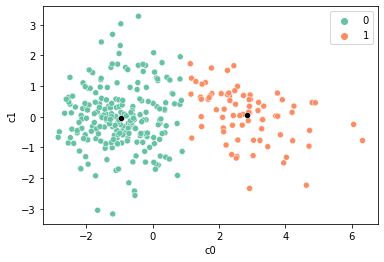



KMeans with 3 Clusters


,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,Count
Clusters,,,,,,,
0,-0.047921,-0.086444,-0.075094,0.903161,-0.245784,-0.236651,177
1,-0.225979,-0.316819,-0.213146,2.751151,-0.395844,-0.454286,69
2,-0.120524,-0.305653,-0.135859,1.618370,-0.243746,-0.209623,60


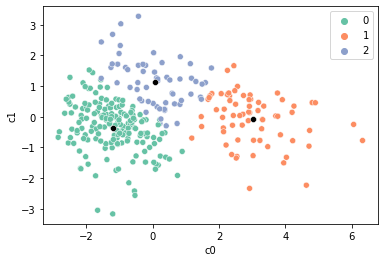



KMeans with 4 Clusters


,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,Count
Clusters,,,,,,,
0,-0.071204,-0.092872,-0.081737,1.152436,-0.293067,-0.302488,89
1,-0.032492,-0.088005,-0.071713,0.750620,-0.205168,-0.178648,96
2,-0.227820,-0.318753,-0.213861,2.767307,-0.396541,-0.454847,68
3,-0.119959,-0.322848,-0.140539,1.584678,-0.239581,-0.203948,53


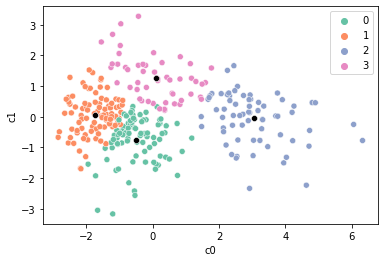



KMeans with 5 Clusters


,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,Count
Clusters,,,,,,,
0,-0.032540,-0.070490,-0.070112,0.729594,-0.209212,-0.186068,94
1,-0.190178,-0.335977,-0.190222,2.195253,-0.350806,-0.387986,52
2,-0.077368,-0.105857,-0.083867,1.219926,-0.292144,-0.300782,89
3,-0.271280,-0.296337,-0.241518,3.332843,-0.444461,-0.513490,28
4,-0.090146,-0.318248,-0.126546,1.445652,-0.211353,-0.162731,43


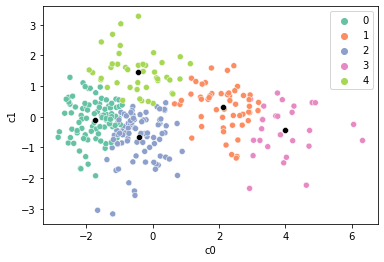



KMeans with 6 Clusters


,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,Count
Clusters,,,,,,,
0,-0.091414,-0.162410,-0.071663,0.734161,-0.248941,-0.245854,79
1,-0.188768,-0.337111,-0.192861,2.281838,-0.353378,-0.390739,53
2,-0.004524,-0.035159,-0.075335,0.787867,-0.202507,-0.170502,63
3,-0.089792,-0.328069,-0.133332,1.544604,-0.209349,-0.155996,37
4,-0.279731,-0.293159,-0.243206,3.269100,-0.449325,-0.520690,26
5,-0.066651,-0.058901,-0.088843,1.584842,-0.309583,-0.325568,48


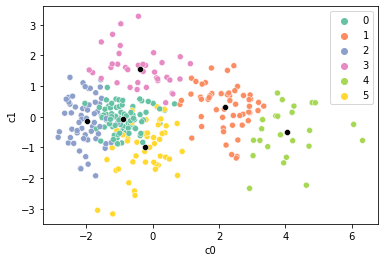

<IPython.core.display.Javascript object>

In [17]:
sse = []
silhouette_scores = []

for n in range(2, 7):
    print(f"KMeans with {n} Clusters")
    km = KMeans(n_clusters=n)
    pred = km.fit_predict(X_std)
    cluster_centers = pd.DataFrame(
        scaler.inverse_transform(km.cluster_centers_), columns=X.columns
    ).rename_axis("Clusters")
    cluster_centers["Count"] = pd.Series(pred).value_counts()
    display(cluster_centers.style.background_gradient())

    sse.append(km.inertia_)
    score = silhouette_score(X_std, km.labels_)
    silhouette_scores.append(score)

    pca_centers = pca.transform(km.cluster_centers_)
    sns.scatterplot(x=pca_df["c0"], y=pca_df["c1"], hue=pred, palette="Set2")
    sns.scatterplot(x=pca_centers[:, 0], y=pca_centers[:, 1], color="black")
    plt.legend()
    plt.show()
    print("\n")

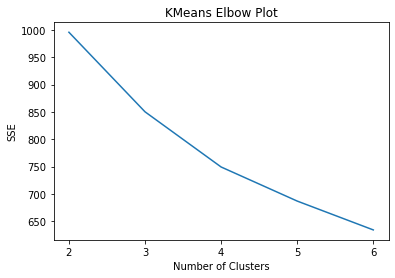

<IPython.core.display.Javascript object>

In [18]:
plt.plot(range(2, 7), sse)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("KMeans Elbow Plot")
plt.show()

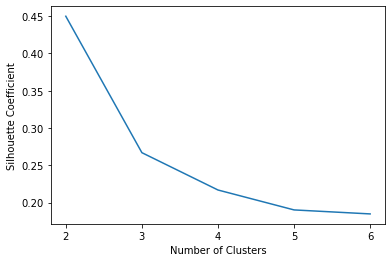

<IPython.core.display.Javascript object>

In [19]:
plt.plot(range(2, 7), silhouette_scores)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [20]:
aggs = {
    "gmm": "count",
    "avg_spending": "mean",
    "avg_jobpost": "mean",
    "avg_emprate": "mean",
    "avg_uiclaimrate": "mean",
    "avg_sbopen": "mean",
    "avg_sbrev": "mean",
}

colnames = [
    "Count",
    "avg_spending",
    "avg_jobpost",
    "avg_emprate",
    "avg_uiclaimrate",
    "avg_sbopen",
    "avg_sbrev",
]

<IPython.core.display.Javascript object>

In [21]:
gmm = GaussianMixture(n_components=4, covariance_type="full")
X["gmm"] = gmm.fit_predict(X_std)

<IPython.core.display.Javascript object>

In [22]:
gmm_summary = X.groupby("gmm").agg(aggs)
gmm_summary.columns = colnames
gmm_summary.style.background_gradient()

,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
gmm,,,,,,,
0,33,-0.259130,-0.308220,-0.194025,2.978939,-0.392443,-0.451927
1,141,-0.060124,-0.105229,-0.070852,0.700560,-0.236603,-0.226816
2,62,-0.045103,-0.116887,-0.103775,1.874600,-0.265644,-0.247874
3,70,-0.164011,-0.332068,-0.190332,1.906884,-0.323717,-0.336394


<IPython.core.display.Javascript object>

GMM with 2 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
gmm,,,,,,,
0,89,-0.202352,-0.331101,-0.203455,2.541737,-0.364477,-0.397326
1,217,-0.061275,-0.119965,-0.083146,1.016482,-0.244255,-0.232481


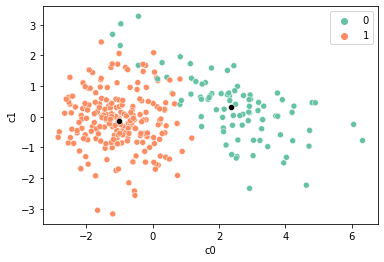



GMM with 3 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
gmm,,,,,,,
0,163,-0.054293,-0.095786,-0.075493,0.743550,-0.241158,-0.233403
1,64,-0.084371,-0.222428,-0.114475,1.852634,-0.247388,-0.217180
2,79,-0.215905,-0.324705,-0.209095,2.620557,-0.383546,-0.428685


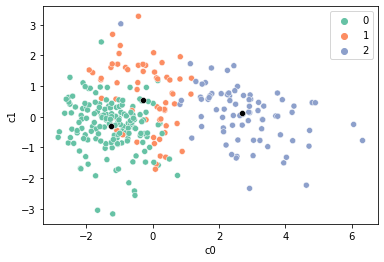



GMM with 4 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
gmm,,,,,,,
0,35,-0.202537,-0.294823,-0.238671,2.879037,-0.415957,-0.499106
1,140,-0.059957,-0.102979,-0.075083,0.698033,-0.233730,-0.228064
2,71,-0.178239,-0.340102,-0.163380,1.917086,-0.303373,-0.300888
3,60,-0.052803,-0.110287,-0.094753,1.869784,-0.277025,-0.250826


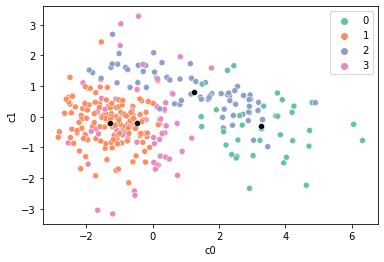



GMM with 5 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
gmm,,,,,,,
0,38,-0.062947,-0.109163,-0.120235,2.141436,-0.304568,-0.325323
1,72,-0.168440,-0.343934,-0.168113,1.993989,-0.298959,-0.284004
2,31,-0.244308,-0.297585,-0.229389,3.128719,-0.430590,-0.505708
3,116,-0.085965,-0.130825,-0.073841,0.738186,-0.252385,-0.249143
4,49,0.015493,-0.044654,-0.077561,0.800603,-0.198328,-0.171882


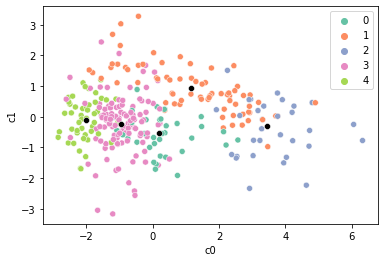



GMM with 6 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
gmm,,,,,,,
0,55,0.008032,-0.050888,-0.069286,0.687786,-0.209010,-0.169150
1,86,-0.093204,-0.137371,-0.075930,0.735883,-0.243960,-0.245225
2,13,-0.085956,-0.341793,-0.246626,1.942100,-0.358053,-0.412561
3,65,-0.243083,-0.324961,-0.201515,2.773606,-0.390626,-0.435211
4,49,-0.066903,-0.065895,-0.090822,1.798691,-0.303348,-0.317212
5,38,-0.093053,-0.318233,-0.133017,1.368668,-0.212004,-0.163749


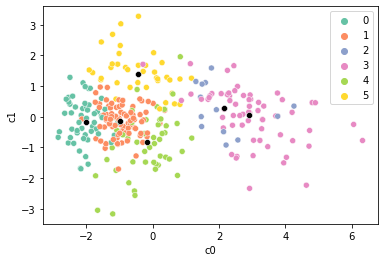

<IPython.core.display.Javascript object>

In [23]:
for n in range(2, 7):
    print(f"GMM with {n} Clusters")
    gmm = GaussianMixture(n_components=n, covariance_type="full")
    X["gmm"] = gmm.fit_predict(X_std)
    gmm_summary = X.groupby("gmm").agg(aggs)
    gmm_summary.columns = colnames
    display(gmm_summary.style.background_gradient())

    pca_centers = pca.transform(gmm.means_)
    sns.scatterplot(x=pca_df["c0"], y=pca_df["c1"], hue=X["gmm"], palette="Set2")
    sns.scatterplot(x=pca_centers[:, 0], y=pca_centers[:, 1], color="black")
    plt.legend()
    plt.show()
    print("\n")

Agglomerative with 2 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
Agglomerative,,,,,,,
0,304,-0.101144,-0.180737,-0.116615,1.431953,-0.277713,-0.278157
1,2,-0.279083,-0.278037,-0.349667,5.738750,-0.508417,-0.625367


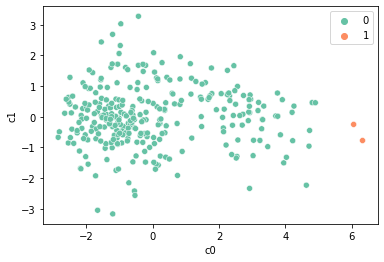



Agglomerative with 3 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
Agglomerative,,,,,,,
0,226,-0.060949,-0.131018,-0.085953,1.058697,-0.242742,-0.227824
1,2,-0.279083,-0.278037,-0.349667,5.738750,-0.508417,-0.625367
2,78,-0.217607,-0.324798,-0.205456,2.513438,-0.379039,-0.423992


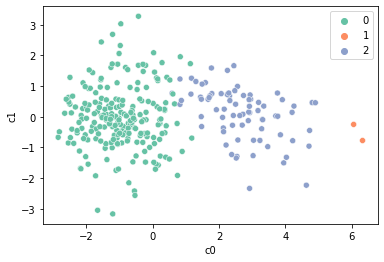



Agglomerative with 4 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
Agglomerative,,,,,,,
0,78,-0.217607,-0.324798,-0.205456,2.513438,-0.379039,-0.423992
1,222,-0.060852,-0.126640,-0.084655,1.029302,-0.244076,-0.230936
2,4,-0.066321,-0.373950,-0.157960,2.690100,-0.168710,-0.055114
3,2,-0.279083,-0.278037,-0.349667,5.738750,-0.508417,-0.625367


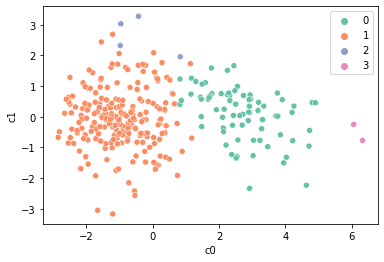



Agglomerative with 5 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
Agglomerative,,,,,,,
0,72,-0.205132,-0.331876,-0.210253,2.627325,-0.374345,-0.408336
1,222,-0.060852,-0.126640,-0.084655,1.029302,-0.244076,-0.230936
2,4,-0.066321,-0.373950,-0.157960,2.690100,-0.168710,-0.055114
3,2,-0.279083,-0.278037,-0.349667,5.738750,-0.508417,-0.625367
4,6,-0.367305,-0.239854,-0.147891,1.146800,-0.435377,-0.611861


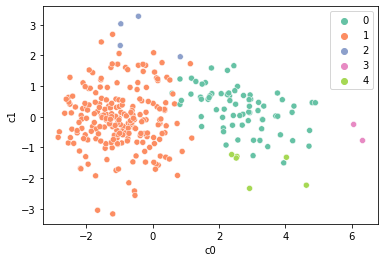



Agglomerative with 6 Clusters


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
Agglomerative,,,,,,,
0,4,-0.066321,-0.373950,-0.157960,2.690100,-0.168710,-0.055114
1,222,-0.060852,-0.126640,-0.084655,1.029302,-0.244076,-0.230936
2,66,-0.223660,-0.335239,-0.205175,2.680771,-0.374455,-0.398114
3,2,-0.279083,-0.278037,-0.349667,5.738750,-0.508417,-0.625367
4,6,-0.367305,-0.239854,-0.147891,1.146800,-0.435377,-0.611861
5,6,-0.001331,-0.294885,-0.266106,2.039417,-0.373135,-0.520783


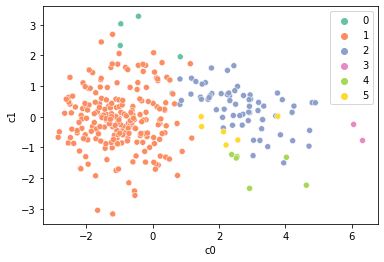

<IPython.core.display.Javascript object>

In [24]:
for n in range(2, 7):
    print(f"Agglomerative with {n} Clusters")
    aggl = AgglomerativeClustering(
        n_clusters=n, affinity="euclidean", linkage="average"
    )
    X["Agglomerative"] = aggl.fit_predict(X_std)
    aggl_summary = X.groupby("Agglomerative").agg(aggs)
    aggl_summary.columns = colnames
    display(aggl_summary.style.background_gradient())

    score = silhouette_score(X_std, X["Agglomerative"])
    silhouette_scores.append(score)

    sns.scatterplot(
        x=pca_df["c0"], y=pca_df["c1"], hue=X["Agglomerative"], palette="Set2"
    )
    plt.legend()
    plt.show()
    print("\n")

DBSCAN Clustering


,Count,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev
DBSCAN,,,,,,,
-1,63,-0.115065,-0.190776,-0.162460,2.324826,-0.320831,-0.343662
0,236,-0.093124,-0.175754,-0.103647,1.210841,-0.263195,-0.255324
1,4,-0.278842,-0.291306,-0.266725,3.148750,-0.478008,-0.546033
2,3,-0.321393,-0.279393,-0.129224,0.657900,-0.401106,-0.573006


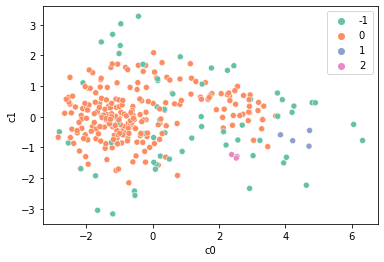

<IPython.core.display.Javascript object>

In [25]:
print("DBSCAN Clustering")
dbscan = DBSCAN(eps=1, min_samples=3, metric="euclidean")
X["DBSCAN"] = dbscan.fit_predict(X_std)
db_summary = X.groupby("DBSCAN").agg(aggs)
db_summary.columns = colnames
display(db_summary.style.background_gradient())

sns.scatterplot(x=pca_df["c0"], y=pca_df["c1"], hue=X["DBSCAN"], palette="Set2")
plt.legend()
plt.show()
print("\n")

## Model Selection and Labeling

In the end, KMeans with 4 clusters appeared to have the best results. The only alternative was to use GMM instead, but KMeans offered the best separation and the most balanced cluster counts. As for why 4 clusters was chosen, the elbow plot wasn't very clear on which number was best, but looks like 3,4, and 5 appear to do well on the PCA plots and cluster center tables. Since, 4 is right in the middle of the 3 options, it was a safe choice.

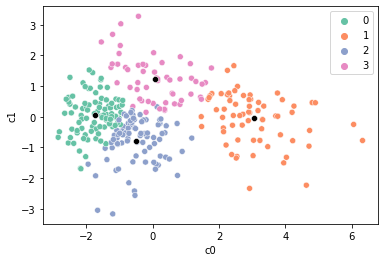

<IPython.core.display.Javascript object>

In [26]:
km4 = KMeans(n_clusters=4, random_state=42)
km4_preds = km4.fit_predict(X_std)
econ_df_merged["clusters"] = km4_preds
km4_cluster_centers = pd.DataFrame(
    scaler.inverse_transform(km4.cluster_centers_), columns=X_std.columns
).rename_axis("Clusters")
km4_cluster_centers["Count"] = pd.Series(km4_preds).value_counts()


pca_centers = pca.transform(km4.cluster_centers_)
sns.scatterplot(x=pca_df["c0"], y=pca_df["c1"], hue=km4_preds, palette="Set2")
sns.scatterplot(x=pca_centers[:, 0], y=pca_centers[:, 1], color="black")
plt.legend()
plt.show()

In [27]:
display(km4_cluster_centers.style.background_gradient())

,avg_spending,avg_jobpost,avg_emprate,avg_uiclaimrate,avg_sbopen,avg_sbrev,Count
Clusters,,,,,,,
0,-0.032492,-0.088005,-0.071713,0.750620,-0.205168,-0.178648,96
1,-0.227820,-0.318753,-0.213861,2.767307,-0.396541,-0.454847,68
2,-0.070528,-0.089573,-0.081465,1.158389,-0.293945,-0.303237,87
3,-0.119255,-0.319704,-0.138831,1.559545,-0.240138,-0.206346,55


<IPython.core.display.Javascript object>

From the table above, there are four cluster archetypes that explain the economic status of each US state during COVID. The values for Cluster 0 are closest to zero, i.e. close to their January normalization value. Cluster 1 is the opposite and has all furthest from zero, meaning the economy is at its worse in this cluster. Cluster 2 and Cluster 3 appear to be in the middle, likely indicating phases when the economy is stabilizing out of Cluster 1. However the key differences for these two are for Cluster 2, small businesses are greatly suffering, and for Cluster 3, job postings are extremely low. 

The following is how the clusters will be re-ranked and defined:

Cluster 0 -> 3 - Economy is Stable (Metrics at or very nearly at pre-COVID levels)

Cluster 2 -> 2 - Economy is stabilizing except for small businesses

Cluster 3 -> 1 - Economy is stabilizing except for job postings

Cluster 1 -> 0 - Severe Economic instability (All metrics are low)

In [28]:
econ_df_merged["new_clusters"] = econ_df_merged["clusters"].replace({0: 3, 1: 0, 3: 1})

<IPython.core.display.Javascript object>

## Visualizations

With the clusters labeled, the last step is to try to visualize and see if it can provide any inferences from the data. First will be both the PCA and UMAP visualizations with the new cluster labels. Following those will be a choropleth where we can see how each states transitions cluster to cluster by month.

In [29]:
@interact()
def pca_scatter():
    pca = PCA(n_components=2, random_state=42)
    pca_data = pd.DataFrame(pca.fit_transform(X_std))
    pca_data["new_clusters"] = econ_df_merged["new_clusters"].astype("str")

    fig = px.scatter(
        pca_data,
        x=0,
        y=1,
        color="new_clusters",
        title=f"PCA of KMeans with 4 clusters",
    )
    fig.update_traces(marker_line_color="black", marker_line_width=1)
    fig.show()

interactive(children=(Output(),), _dom_classes=('widget-interact',))

<IPython.core.display.Javascript object>

In [30]:
@interact(n_neighbors=range(2, 25, 2), min_dist=np.arange(0, 1.0, 0.05))
def umap_scatter(n_neighbors, min_dist):
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    data_umap = pd.DataFrame(umap_model.fit_transform(X_std))
    data_umap["new_clusters"] = econ_df_merged["new_clusters"].astype("str")

    fig = px.scatter(
        data_umap,
        x=0,
        y=1,
        color="new_clusters",
        title=f"UMAP {n_neighbors} n_neighbors and {min_dist} min_dist",
    )
    fig.update_traces(marker_line_color="black", marker_line_width=1)
    fig.show()

interactive(children=(Dropdown(description='n_neighbors', options=(2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24)…

<IPython.core.display.Javascript object>

In [31]:
months = ["April", "May", "June", "July", "August", "September"]
econ_dfs_months = {}
for i, month in enumerate(months):
    econ_dfs_months[month] = econ_df_merged.loc[econ_df_merged["month"] == (i + 4)]

<IPython.core.display.Javascript object>

In [34]:
@interact(month=["April", "May", "June", "July", "August", "September"])
def usa_map(month):
    fig = go.Figure(
        data=go.Choropleth(
            locations=econ_dfs_months[month]["stateabbrev"],
            z=econ_dfs_months[month]["new_clusters"],
            #             zmin=0,
            #             zmax=3,
            locationmode="USA-states",
            colorscale="spectral",
            colorbar=dict(
                title="Cluster Number",
                tickvals=[0, 1, 2, 3],
                ticktext=[
                    "0- Unstable",
                    "1- Stabilizing/low job posting",
                    "2- Stabilizing/low small business growth",
                    "3- Stable",
                ],
                lenmode="pixels",
                len=200,
            ),
        )
    )

    fig.update_layout(
        title_text="Economic State After COVID by State",
        geo_scope="usa",  # limite map scope to USA
    )

    fig.show()

interactive(children=(Dropdown(description='month', options=('April', 'May', 'June', 'July', 'August', 'Septem…

<IPython.core.display.Javascript object>

In [33]:
fig = px.choropleth(
    econ_df_merged,
    locations="stateabbrev",
    color="new_clusters",
    animation_frame="month",
    color_continuous_scale="spectral",
    locationmode="USA-states",
    scope="usa",
    range_color=(0, 3),
    title="Economic Status After COVID by Month per State",
    height=600,
)

fig.update_layout(
    coloraxis_colorbar=dict(
        title="Cluster Number",
        tickvals=[0, 1, 2, 3],
        ticktext=[
            "0- Unstable",
            "1- Stabilizing/low job posting",
            "2- Stabilizing/low small business growth",
            "3- Stable",
        ],
        lenmode="pixels",
        len=200,
    )
)

fig.show()

<IPython.core.display.Javascript object>

## Conclusion

As you can see, it has been a roller coast year for the economy across all states. In April, almost every state was in the unstable cluster, as this is when all the lockdowns were in affect nation wide. As we transitioned into May, some metrics started to get better but unsurprisingly jobs were not being created at this time (low job postings). In June, most of rural America (or states that ignored or lifted lockdowns) appear to have stabilized, while states with bigger economies and stricter regulations were still stabilizing but leaving small businesses behind. For the remaining months, very few states reach stability if they haven't done so already, but most states are stabilizing (besides small businesses) or stable, with few exceptions (poor Hawaii). 

For future considerations, I would like to go back and aggregate data weekly instead of monthly. This would increase the amount of data points and could potentially lead to more accurate clustering. Another increasing addition would be to add COVID data to the map above and see how certain economic levels are indicative of COVID metrics as well. 

Furthermore, I would like to continue to add data as time goes, though I don't know how effective these clusters can be used for predictive analysis for the future as it is highly dependent on this year and fit to this year's abnormal data.